In [1]:
from sklearn.cluster import KMeans

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import esp
%matplotlib inline

### Find regions of color space spanned by training space as a function of wavelength

#### Load catalogs

In [3]:
# Load in training set with a k-means group taken out
color_gap_train_set = pd.read_csv('../data/train_cat_4_group_color_cut_0.dat')

In [4]:
# Load training set with full colors
full_train_set = pd.read_csv('../data/train_cat_full.dat')

In [66]:
# Load test set with full colors
full_test_set = pd.read_csv('../data/test_cat_full.dat')

In [6]:
#full_test_set = full_test_set.iloc[::10]
#full_test_set = full_test_set.reset_index(drop=True)

In [7]:
# Create set of redshift bins
z_vals = np.arange(0, 3.51, 0.05)

In [8]:
# Bin by redshift
z_bins = np.digitize(color_gap_train_set['redshift'], z_vals)
z_bins_full = np.digitize(full_train_set['redshift'], z_vals)

In [9]:
# Get bin numbers to start at zero
z_bins = z_bins-1
z_bins_full =z_bins_full-1

In [10]:
# Label each galaxy by its redshift bin
color_gap_train_set['z_bins'] = z_bins
full_train_set['z_bins'] = z_bins_full

In [11]:
filters = ['u', 'g', 'r', 'i', 'z', 'y']

In [12]:
colors = ['u-g', 'g-r', 'r-i', 'i-z', 'z-y']

In [13]:
# Calculate colors from catalog magnitudes
for i in range(5):
    color_gap_train_set['%s-%s' % (filters[i], filters[i+1])] = \
        color_gap_train_set[filters[i]]-color_gap_train_set[filters[i+1]]

In [14]:
# Calculate colors from catalog magnitudes
for i in range(5):
    full_train_set['%s-%s' % (filters[i], filters[i+1])] = \
        full_train_set[filters[i]]-full_train_set[filters[i+1]]

In [67]:
# Calculate colors from catalog magnitudes
for i in range(5):
    full_test_set['%s-%s' % (filters[i], filters[i+1])] = \
        full_test_set[filters[i]]-full_test_set[filters[i+1]]

In [16]:
cluster_centers = {}
cluster_centers_f = {}

In [17]:
color_gap_train_set.head()

,redshift,u,g,r,i,z,y,z_bins,u-g,g-r,r-i,i-z,z-y
0,0.708277,27.5278,27.4826,27.0514,26.4112,26.3398,26.3135,14,0.0452,0.4312,0.6402,0.0714,0.0263
1,3.297912,31.7478,26.6329,25.4428,25.3954,25.7079,25.7969,65,5.1149,1.1901,0.0474,-0.3125,-0.0890
2,2.175147,26.4805,26.1697,26.2675,26.3462,26.2657,26.2155,43,0.3108,-0.0978,-0.0787,0.0805,0.0502
3,2.100762,30.7369,28.4791,27.5407,27.2548,26.6204,26.2846,42,2.2578,0.9384,0.2859,0.6344,0.3358
4,2.097417,26.6531,26.4531,26.5904,26.6739,26.6440,26.6244,41,0.2000,-0.1373,-0.0835,0.0299,0.0196


Our goal is to generate a new set of templates in each redshift bin. We will then blueshift each bin the appropriate amount to get rest frame colors.

To create the templates for each bin we will generate ESP templates at the locations of 50 cluster centers in the color space of all galaxies observed
within the redshift bin.

In [18]:
# Cluster the galaxies in each redshift bin and keep the locations of the cluster centers
for bin_idx in range(70):
    if bin_idx % 5 == 0:
        print(bin_idx)
    km = KMeans(n_clusters=50, random_state=18).fit(
        color_gap_train_set.query('z_bins == %i' % bin_idx)[['u-g', 'g-r', 'r-i', 'i-z', 'z-y']])
    cluster_centers[str(bin_idx)] = km.cluster_centers_

0
5
10
15
20
25
30
35
40
45
50
55
60
65


In [19]:
# Cluster the galaxies in each redshift bin and keep the locations of the cluster centers
for bin_idx in range(70):
    if bin_idx % 5 == 0:
        print(bin_idx)
    km = KMeans(n_clusters=50, random_state=18).fit(
        full_train_set.query('z_bins == %i' % bin_idx)[['u-g', 'g-r', 'r-i', 'i-z', 'z-y']])
    cluster_centers_f[str(bin_idx)] = km.cluster_centers_

0
5
10
15
20
25
30
35
40
45
50
55
60
65


In [22]:
#f = open('gap_train_centers.pkl', 'wb')
#pickle.dump(cluster_centers, f)
#f.close()

#g = open('full_train_centers.pkl', 'wb')
#pickle.dump(cluster_centers_f, g)
#g.close()

In [25]:
#f = open('gap_train_centers.pkl', 'rb')
#cluster_centers = pickle.load(f)
#f.close()

#g = open('full_train_centers.pkl', 'rb')
#cluster_centers_f = pickle.load(g)
#g.close()

In [ ]:
# Cluster the galaxies in each redshift bin and keep the locations of the cluster centers
#km = KMeans(n_clusters=200, random_state=18, n_jobs=2).fit(
#        full_test_set[['u-g', 'g-r', 'r-i', 'i-z', 'z-y']])
#cluster_centers_test = km.cluster_centers_

In [70]:
cluster_centers_test = np.genfromtxt('../data/cluster_centers_test.dat')

### Fit ESP GP process for each redshift bin of original templates

In [20]:
# Point to the input template directory
template_dir = '../data/templates/brown/'

In [21]:
pca_obj = esp.pcaSED()
pca_obj.load_full_spectra(template_dir)

for pca_sed in pca_obj.spec_list_orig:
    # Templates are in angstroms. Convert to nanometers.
    pca_sed.wavelen /= 10.

File On 100 out of 129
Done loading spectra from file


In [22]:
bandpass_dir = '../../ESP/data/lsst_bandpasses/'
filters = ['u', 'g', 'r', 'i', 'z', 'y']
bandpass_dict = esp.lsst_utils.BandpassDict.loadTotalBandpassesFromFiles(bandpassNames = filters,
                                                          bandpassDir = bandpass_dir,
                                                          bandpassRoot = 'total_')

In [23]:
# Drop file that isn't an SED. Fix this better later.
pca_obj.spec_list_orig = pca_obj.spec_list_orig[:-1]

In [24]:
# Double check we have the right number of SEDs
print(len(pca_obj.spec_list_orig))

129


In [25]:
# Redshift templates to get redshifted training colors and spectra for each redshift bin
from copy import deepcopy
colors_dict = {}
mags = []
spec_val = []
redshift = []
spec_dict = {}
for z_bin_idx in range(70):
    z_shift = z_vals[z_bin_idx]
    test_sed_list = []
    test_colors_list = []
    for sed_obj in pca_obj.spec_list_orig:
        test_sed = deepcopy(sed_obj)
        test_sed.redshiftSED(z_shift, dimming=True)
        test_sed_list.append(test_sed)
        sed_mags = bandpass_dict.magListForSed(test_sed)
        mags.append(sed_mags)
        colors = sed_mags[:-1] - sed_mags[1:]
        test_colors_list.append(colors)

    spec_dict[str(z_bin_idx)] = test_sed_list
    colors_dict[str(z_bin_idx)] = test_colors_list

In [26]:
# Run the template estimation in each redshift bin and get new templates at the centers of the 50 clusters for each redshift bin
final_z = np.zeros(50*50)
final_colors = np.zeros((50*50, 5))
final_spec = []
for z_bin_idx in range(50):
    if z_bin_idx % 5 == 0:
        print(z_bin_idx)
    z_shift = z_vals[z_bin_idx]
    pca_obj.spec_list_orig = spec_dict[str(z_bin_idx)]
    pca_obj.PCA(comps=10, minWavelen=199., maxWavelen=1500.*(1+z_shift))
    #print(pca_obj.wavelengths, pca_obj.spec_list_orig[0].wavelen)
    gp_obj = esp.gaussianProcessEstimate(pca_obj, bandpass_dict, cluster_centers[str(z_bin_idx)])#colors_dict[str(z_bin_idx)])
    gp_kernel = gp_obj.define_kernel('exp', 1.0e-3, 1.0e-3, n_dim=5)
    gp_spec = gp_obj.gp_predict(gp_kernel, opt_bandpass_dict=bandpass_dict)
    gp_colors = gp_spec.calc_colors(bandpass_dict, 10)
    new_spec = gp_spec.reconstruct_spectra(10)

    new_colors = []
    for spec_flambda in new_spec:
        test_sed = esp.lsst_utils.Sed()
        test_sed.setSED(wavelen=pca_obj.wavelengths, flambda=spec_flambda)
        test_sed.redshiftSED(-1.0*z_shift, dimming=True)
        final_spec.append(test_sed.flambda)
        sed_mags = bandpass_dict.magListForSed(test_sed)
        new_colors.append(sed_mags[:-1] - sed_mags[1:])
    final_z[z_bin_idx*50:(z_bin_idx+1)*50] = z_shift
    final_colors[z_bin_idx*50:(z_bin_idx+1)*50] = new_colors

0
5
10
15
20
25
30
35
40
45


In [27]:
# Run the template estimation in each redshift bin and get new templates at the centers of the 50 clusters for each redshift bin
final_z_full = np.zeros(50*50)
final_colors_full = np.zeros((50*50, 5))
final_mags_full = np.zeros((50*50, 6))
final_spec_full = []
for z_bin_idx in range(50):
    if z_bin_idx % 5 == 0:
        print(z_bin_idx)
    z_shift = z_vals[z_bin_idx]
    pca_obj.spec_list_orig = spec_dict[str(z_bin_idx)]
    pca_obj.PCA(comps=10, minWavelen=199., maxWavelen=1500.*(1+z_shift))
    #print(pca_obj.wavelengths, pca_obj.spec_list_orig[0].wavelen)
    gp_obj = esp.gaussianProcessEstimate(pca_obj, bandpass_dict, cluster_centers_f[str(z_bin_idx)])#colors_dict[str(z_bin_idx)])
    gp_kernel = gp_obj.define_kernel('exp', 1.0e-3, 1.0e-3, n_dim=5)
    gp_spec = gp_obj.gp_predict(gp_kernel, opt_bandpass_dict=bandpass_dict)
    gp_colors = gp_spec.calc_colors(bandpass_dict, 10)
    new_spec = gp_spec.reconstruct_spectra(10)

    new_colors = []
    new_mags = []
    for spec_flambda in new_spec:
        test_sed = esp.lsst_utils.Sed()
        test_sed.setSED(wavelen=pca_obj.wavelengths, flambda=spec_flambda)
        test_sed.redshiftSED(-1.0*z_shift, dimming=True)
        final_spec_full.append(test_sed)
        sed_mags = bandpass_dict.magListForSed(test_sed)
        new_mags.append(sed_mags)
        new_colors.append(sed_mags[:-1] - sed_mags[1:])
    final_z_full[z_bin_idx*50:(z_bin_idx+1)*50] = z_shift
    final_colors_full[z_bin_idx*50:(z_bin_idx+1)*50] = new_colors
    final_mags_full[z_bin_idx*50:(z_bin_idx+1)*50] = new_mags

0
5
10
15
20
25
30
35
40
45


In [28]:
# Compile all the colors into one array
cluster_centers_gap = np.zeros((50*70, 5))
cl_z_gap = np.zeros((50*70))
for cl_idx in range(70):
    cluster_centers_gap[cl_idx*50:(cl_idx + 1)*50] = cluster_centers[str(cl_idx)]
    cl_z_gap[cl_idx*50:(cl_idx + 1)*50] = z_vals[cl_idx]

In [29]:
cluster_centers_full = np.zeros((50*70, 5))
cl_z_full = np.zeros((50*70))
for cl_idx in range(70):
    cluster_centers_full[cl_idx*50:(cl_idx + 1)*50] = cluster_centers_f[str(cl_idx)]
    cl_z_full[cl_idx*50:(cl_idx + 1)*50] = z_vals[cl_idx]

In [30]:
colors = ['u-g', 'g-r', 'r-i', 'i-z', 'z-y']

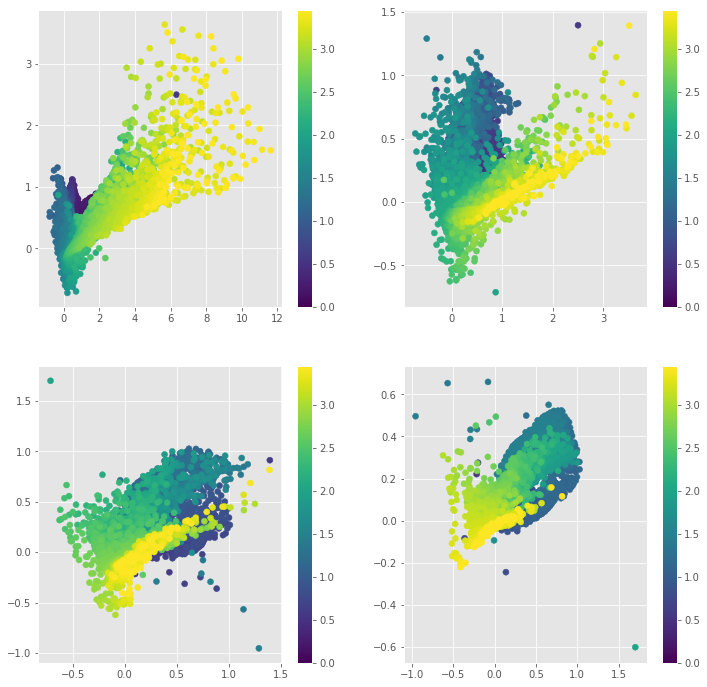

In [31]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(cluster_centers_gap[:,i], cluster_centers_gap[:,i+1], c=cl_z_full)
    plt.colorbar()

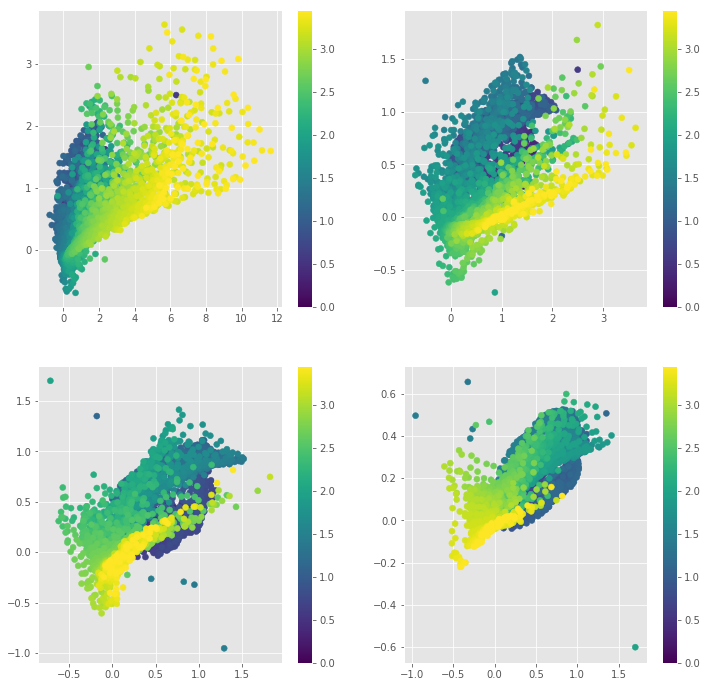

In [32]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(cluster_centers_full[:,i], cluster_centers_full[:,i+1], c=cl_z_full)
    plt.colorbar()

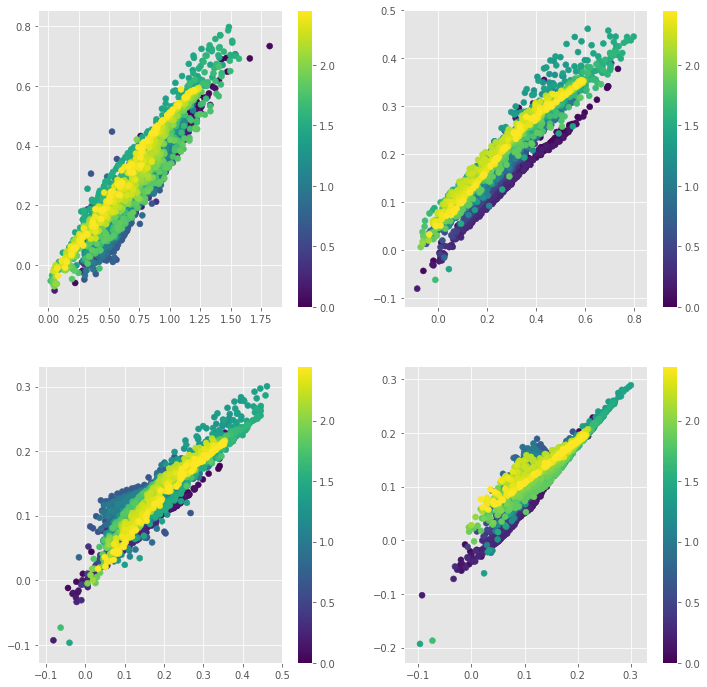

In [33]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(final_colors[:,i], final_colors[:,i+1], c=final_z)
    plt.colorbar()

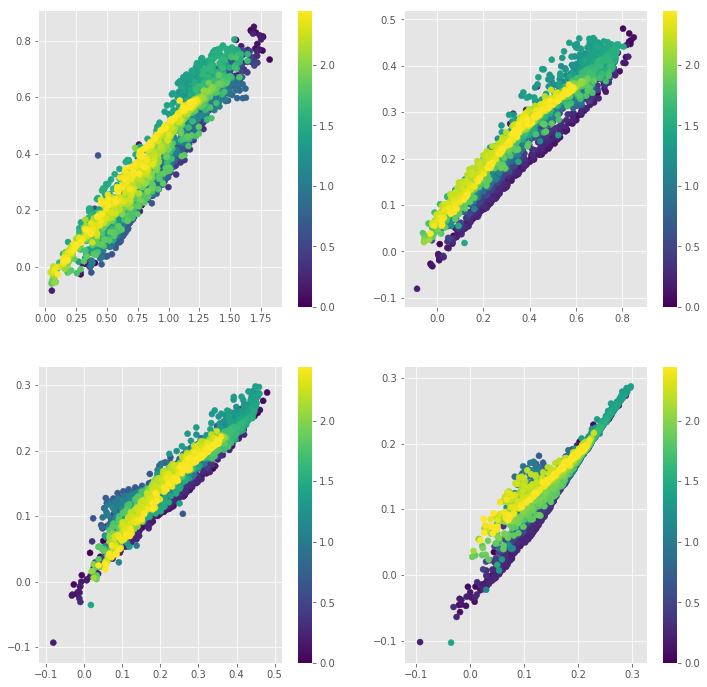

In [34]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(final_colors_full[:,i], final_colors_full[:,i+1], c=final_z)
    plt.colorbar()

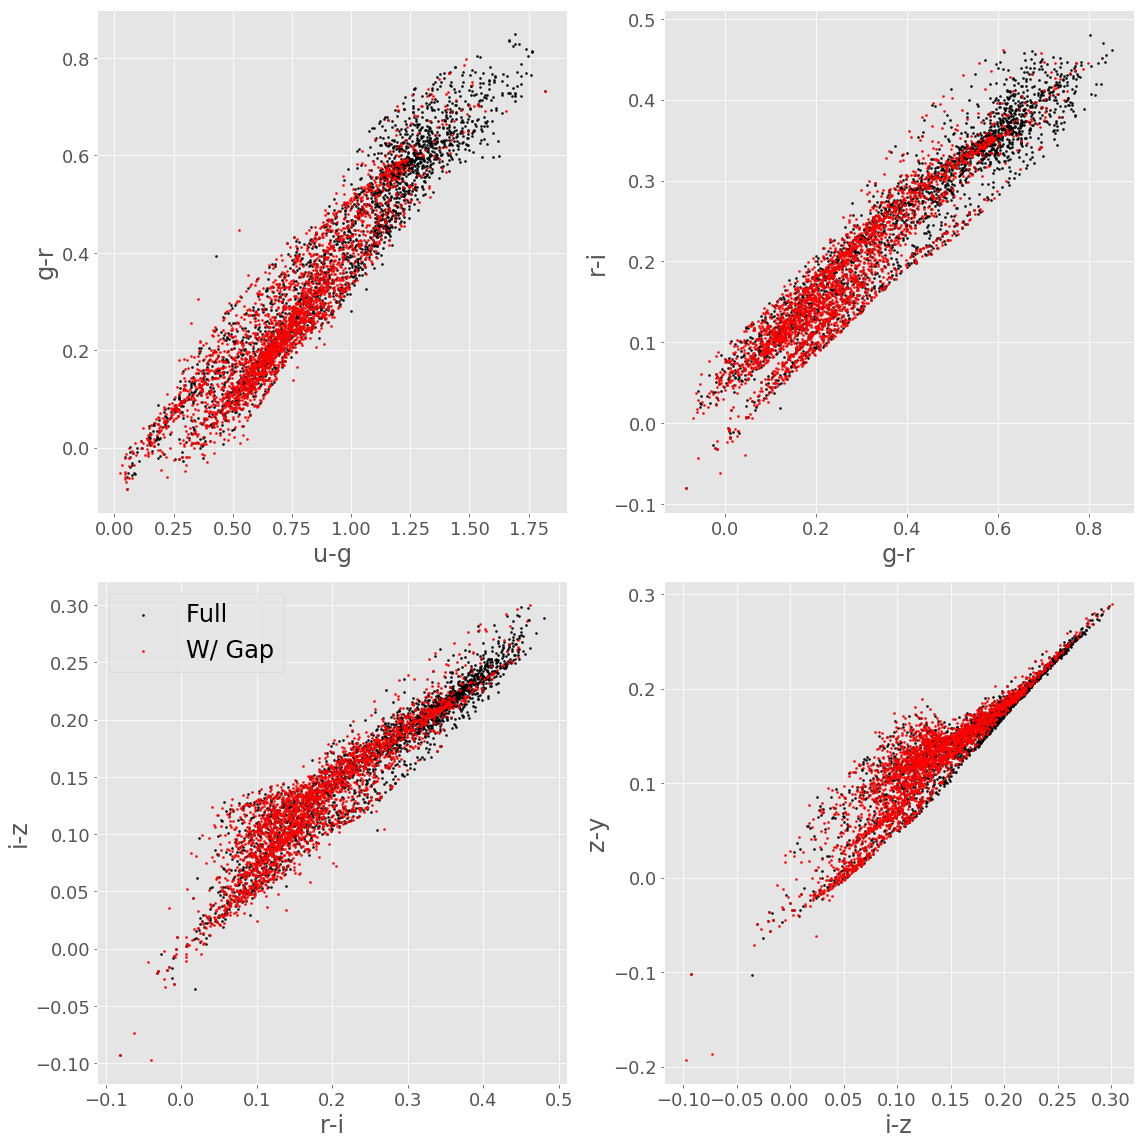

In [35]:
fig = plt.figure(figsize=(16,16))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(final_colors_full[:,i], final_colors_full[:,i+1], c='k', label='Full', s=4, alpha=1.)
    plt.scatter(final_colors[:,i], final_colors[:,i+1], c='r', label='W/ Gap', s=4, alpha=1.)
    plt.xlabel(colors[i], size=24)
    plt.ylabel(colors[i+1], size=24)
    if i == 2:
        plt.legend(fontsize=24)
    plt.xticks(size=18)
    plt.yticks(size=18)
plt.tight_layout()

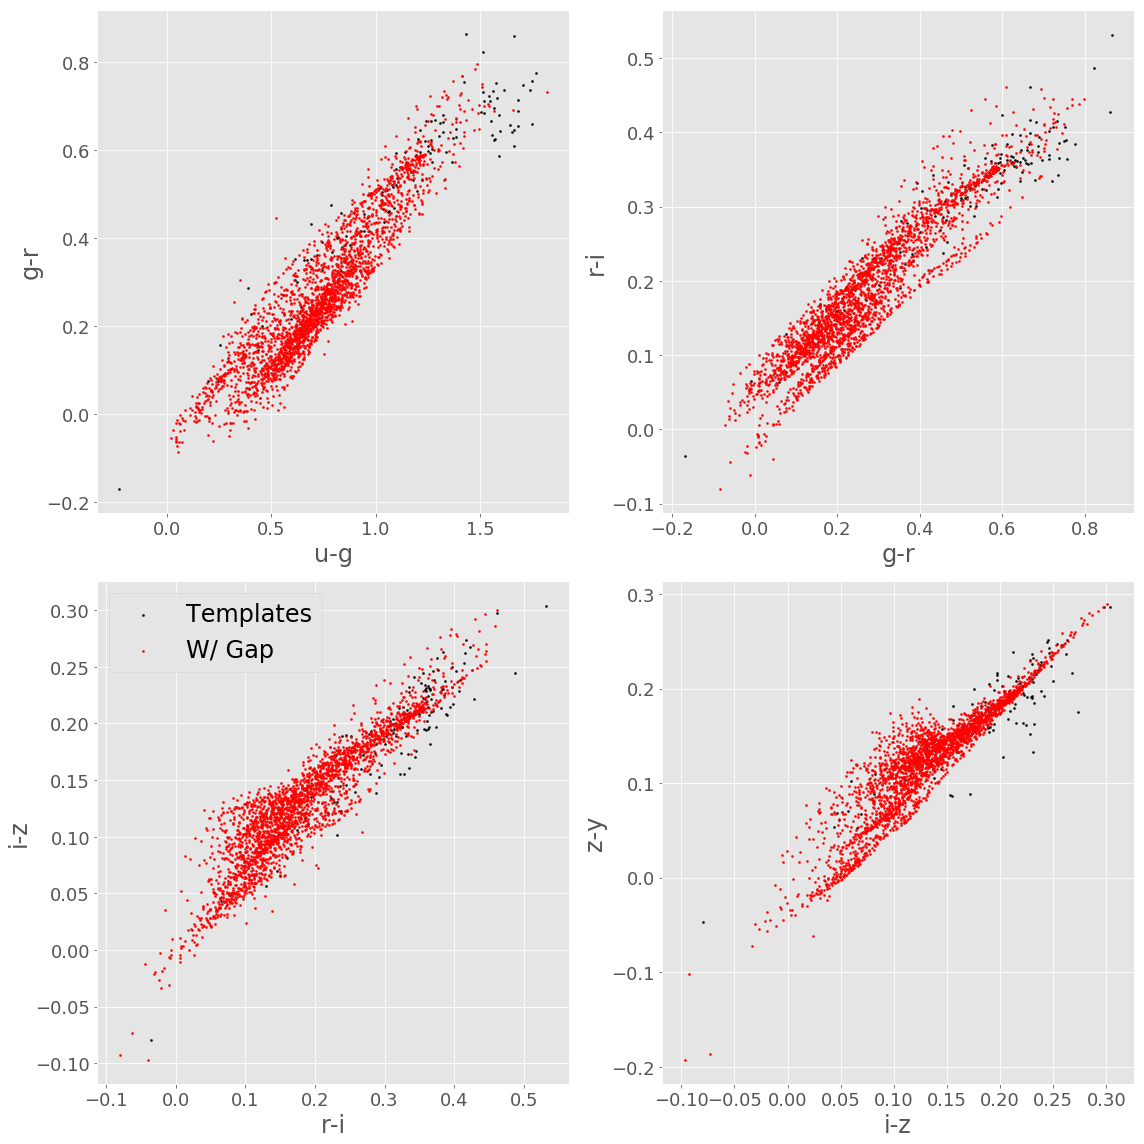

In [36]:
fig = plt.figure(figsize=(16,16))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(np.array(colors_dict['0'])[:,i], np.array(colors_dict['0'])[:,i+1], c='k', label='Templates', s=4, alpha=1.)
    plt.scatter(final_colors[:,i], final_colors[:,i+1], c='r', label='W/ Gap', s=4, alpha=1.)
    plt.xlabel(colors[i], size=24)
    plt.ylabel(colors[i+1], size=24)
    if i == 2:
        plt.legend(fontsize=24)
    plt.xticks(size=18)
    plt.yticks(size=18)
plt.tight_layout()

### Compare the full training set rest frame colors and those of the training set with a gap

We hope to see that there are gaps in the rest frame.

In [1]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=1).fit(final_colors)

NameError: name 'final_colors' is not defined

In [ ]:
# Find the distances between the nearest neighbor in the rest frame colors of the full training set and those in the training set with a gap
distances, indices = nbrs.kneighbors(final_colors_full)

In [ ]:
# Find the distances between the nearest neighbor in the rest frame colors of the full training set and those in the training set with a gap
distances_templates, indices_templates = nbrs.kneighbors(np.array(colors_dict['0']))

In [ ]:
len(np.where(distances > 0.05)[0])

In [ ]:
len(np.where(distances_templates > 0.05)[0])

In [ ]:
# Identify those in the full training set which have no close neighbors in the gap training set and this will identify our rest frame gap colors
keep = np.where(distances > 0.05)[0]
keep_templates = np.where(distances_templates > 0.05)[0]

In [ ]:
fig = plt.figure(figsize=(16,16))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(final_colors_full[keep,i], final_colors_full[keep,i+1], c=final_z[keep], s=48)
    plt.colorbar()
    plt.xlabel(colors[i], size=24)
    plt.ylabel(colors[i+1], size=24)
    plt.xticks(size=18)
    plt.yticks(size=18)

In [ ]:
fig = plt.figure(figsize=(16,16))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(cluster_centers_gap[:,i], cluster_centers_gap[:, i+1], c=cl_z_full)
    plt.colorbar()
    plt.scatter(cluster_centers_full[keep,i], cluster_centers_full[keep,i+1], c='r', s=48)
    plt.xlabel(colors[i], size=24)
    plt.ylabel(colors[i+1], size=24)
    plt.xticks(size=18)
    plt.yticks(size=18)

In [ ]:
fig = plt.figure(figsize=(16,16))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(cluster_centers_full[keep,i], cluster_centers_full[keep,i+1], c=cl_z_full[keep], s=48)
    plt.colorbar()
    plt.xlabel(colors[i], size=24)
    plt.ylabel(colors[i+1], size=24)
    plt.xticks(size=18)
    plt.yticks(size=18)

In [ ]:
sim_mags = []
sim_redshift = []
for keep_idx in keep:
    for z_on in z_vals:
        sim_redshift.append(z_on)
        test_sed = deepcopy(final_spec_full[keep_idx])
        test_sed.redshiftSED(z_on, dimming=True)
        sed_mags = bandpass_dict.magListForSed(test_sed)
        sim_mags.append(sed_mags)

In [60]:
sim_cat_df = pd.DataFrame()
sim_cat_df['redshift'] = cl_z_full[keep]
for i, band in list(enumerate(filters)):
    # Going to use colors anyway so just give u-band standard magnitude
    if band == 'u':
        sim_cat_df['%s' % band] = 25.#final_mags_full[keep, i]
    else:
        sim_cat_df['%s' % band] = sim_cat_df['%s' % filters[i-1]] - cluster_centers_full[keep, i-1]

In [61]:
len(sim_cat_df)

77

In [63]:
sim_cat_df.head()

,redshift,u,g,r,i,z,y
0,0.00,25.0,23.295400,22.357400,21.929100,21.507100,21.304300
1,0.05,25.0,23.222800,22.169350,21.683250,21.179700,20.954650
2,0.05,25.0,23.269200,22.275967,21.879300,21.536567,21.391967
3,0.05,25.0,23.525541,22.720259,22.410124,22.176765,22.088071
4,0.05,25.0,23.336433,22.415622,22.064522,21.763678,21.629133


In [55]:
#np.savetxt('../data/rest_frame_only_train.csv', sim_cat_df.values)

In [65]:
sim_cat_df.to_csv('../data/rest_frame_only_train.csv', index=False)

In [ ]:
fig = plt.figure(figsize=(16,16))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(final_colors_full[keep,i], final_colors_full[keep,i+1], c=final_z[keep], s=48)
    plt.colorbar()
    plt.scatter(np.array(colors_dict['0'])[keep_templates,i], np.array(colors_dict['0'])[keep_templates,i+1], c='r', s=48)
    plt.xlabel(colors[i], size=24)
    plt.ylabel(colors[i+1], size=24)
    plt.xticks(size=18)
    plt.yticks(size=18)

In [2]:
mags_templates = []
redshift_templates = []

for z_bin_idx in range(50):
    z_shift = z_vals[z_bin_idx]
    for sed_obj_idx in keep_templates:
        test_sed = deepcopy(pca_obj.spec_list_orig[sed_obj_idx])
        test_sed.redshiftSED(z_shift, dimming=True)
        test_sed_list.append(test_sed)
        sed_mags = bandpass_dict.magListForSed(test_sed)
        mags_templates.append(sed_mags)
        redshift_templates.append(z_shift)

mags_templates = np.array(mags_templates)
redshift_templates = np.array(redshift_templates)

NameError: name 'z_vals' is not defined

In [ ]:
# Same thing as above but with finer redshift resolution
mags_templates = []
redshift_templates = []

new_z_vals = np.arange(0, 2.51, 0.01)

for z_bin_idx in range(251):
    z_shift = new_z_vals[z_bin_idx]
    for sed_obj_idx in keep_templates:
        test_sed = deepcopy(pca_obj.spec_list_orig[sed_obj_idx])
        test_sed.redshiftSED(z_shift, dimming=True)
        test_sed_list.append(test_sed)
        sed_mags = bandpass_dict.magListForSed(test_sed)
        mags_templates.append(sed_mags)
        redshift_templates.append(z_shift)

mags_templates = np.array(mags_templates)
redshift_templates = np.array(redshift_templates)

In [504]:
t_col = mags_templates[:,:-1] - mags_templates[:,1:]

In [505]:
nbrs = NearestNeighbors(n_neighbors=1).fit(cluster_centers_gap)

In [506]:
# Find the distances between the nearest neighbor in the rest frame colors of the full training set and those in the training set with a gap
distances_t, indices_t = nbrs.kneighbors(t_col)

In [507]:
t_keep = np.where(distances_t > 0.05)[0]
print(len(t_keep))

1999


In [508]:
t_keep

array([   0,    1,    2, ..., 1997, 1998, 1999])

In [509]:
distances_test, indices_test = nbrs.kneighbors(cluster_centers_test)

In [510]:
test_keep = np.where(distances_test > 0.1)[0]
print(len(test_keep))

76


In [511]:
nbrs_test = NearestNeighbors(n_neighbors=1).fit(cluster_centers_test)

In [512]:
distances_test, indices_test = nbrs_test.kneighbors(t_col[t_keep])

In [513]:
t_keep = t_keep[np.where(distances_test < 0.3)[0]]
print(len(t_keep))

190


In [514]:
t_keep

array([   0,   22,   23,   24,   28,   32,   40,   65,   66,   68,   80,
         86,  102,  104,  106,  107,  112,  113,  120,  131,  132,  134,
        135,  136,  137,  138,  139,  140,  145,  146,  154,  160,  171,
        172,  174,  175,  176,  177,  179,  180,  200,  212,  216,  217,
        219,  220,  240,  252,  256,  257,  259,  260,  280,  291,  292,
        295,  296,  297,  299,  300,  312,  320,  331,  332,  334,  336,
        337,  338,  339,  340,  341,  352,  356,  360,  361,  368,  369,
        371,  373,  375,  376,  379,  392,  395,  409,  411,  413,  414,
        415,  416,  417,  419,  421,  431,  437,  444,  449,  450,  451,
        454,  456,  457,  459,  461,  466,  481,  487,  488,  493,  496,
        723,  763,  803,  807,  813,  843,  853, 1173, 1766, 1769, 1771,
       1796, 1797, 1806, 1807, 1809, 1811, 1814, 1819, 1821, 1836, 1837,
       1843, 1846, 1847, 1849, 1851, 1853, 1854, 1856, 1857, 1859, 1861,
       1876, 1877, 1882, 1883, 1886, 1887, 1889, 18

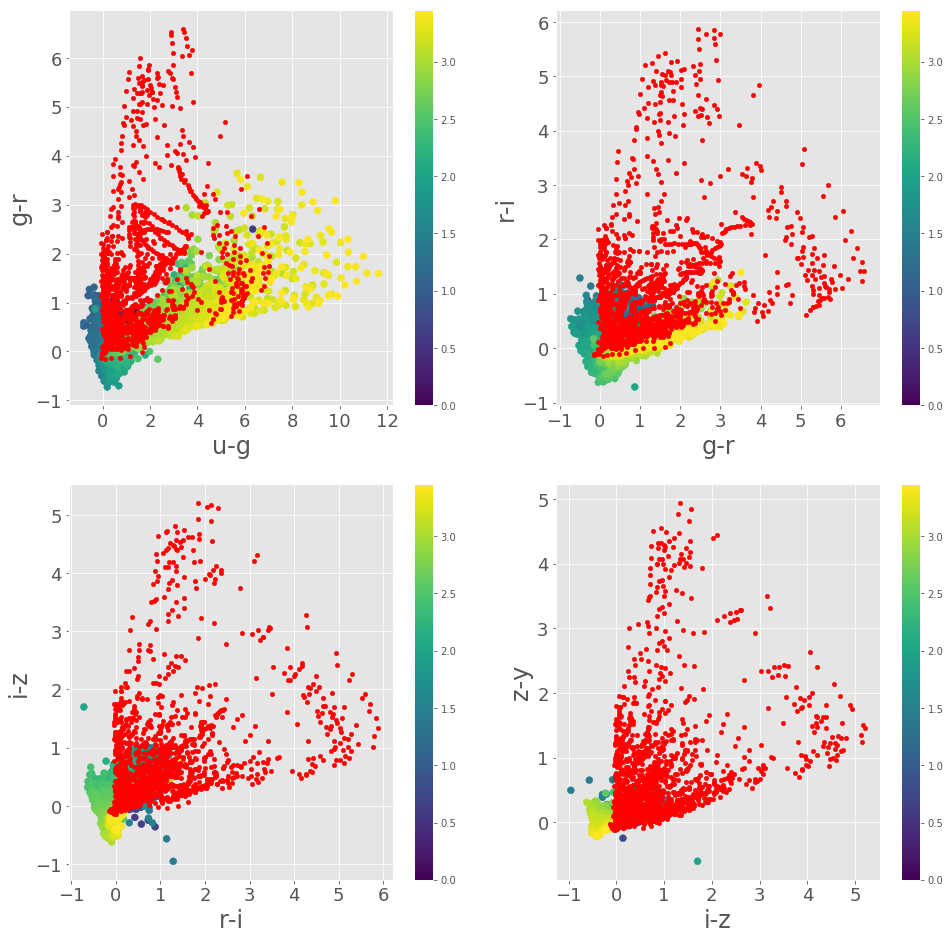

In [467]:
fig = plt.figure(figsize=(16,16))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(cluster_centers_gap[:,i], cluster_centers_gap[:,i+1], c=cl_z_full, s=48)
    plt.colorbar()
    plt.scatter(t_col[:,i], t_col[:,i+1], c='r', s=20)
    plt.xlabel(colors[i], size=24)
    plt.ylabel(colors[i+1], size=24)
    plt.xticks(size=18)
    plt.yticks(size=18)

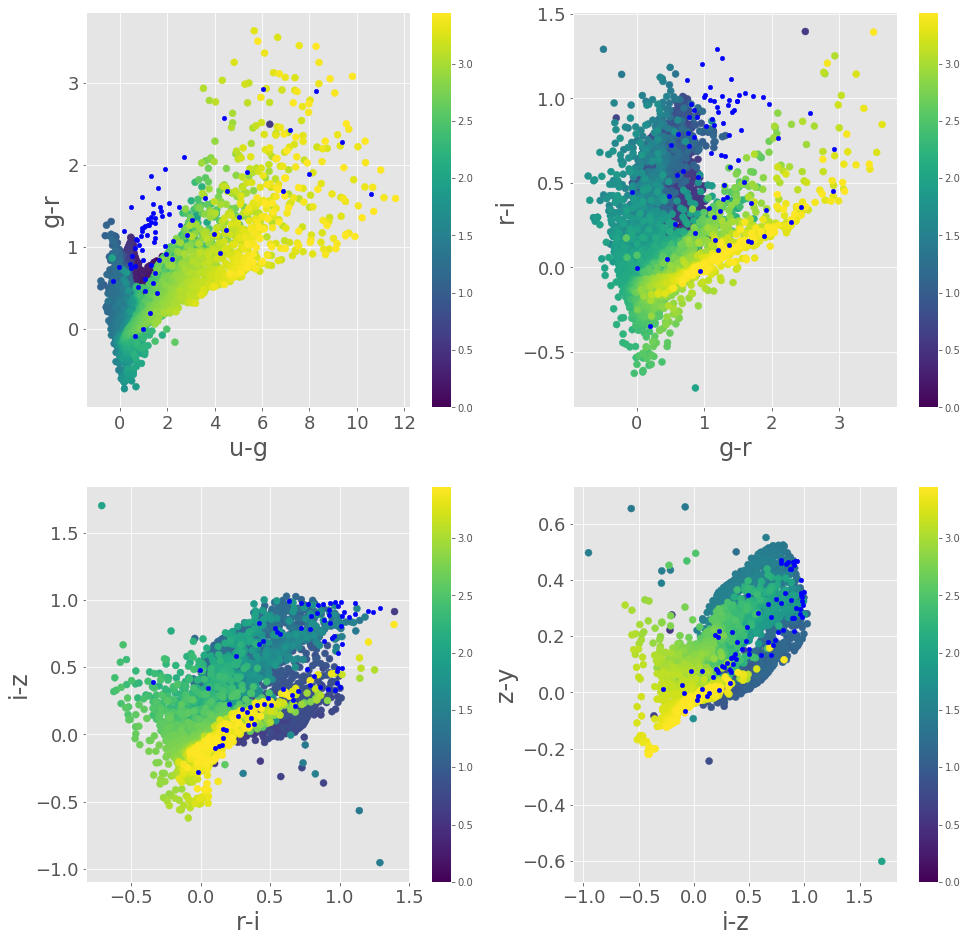

In [468]:
fig = plt.figure(figsize=(16,16))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(cluster_centers_gap[:,i], cluster_centers_gap[:,i+1], c=cl_z_full, s=48)
    plt.colorbar()
    #plt.scatter(t_col[:,i], t_col[:,i+1], c='r', s=20)
    plt.scatter(cluster_centers_test[test_keep,i], cluster_centers_test[test_keep,i+1], c='b', s=20)
    plt.xlabel(colors[i], size=24)
    plt.ylabel(colors[i+1], size=24)
    plt.xticks(size=18)
    plt.yticks(size=18)

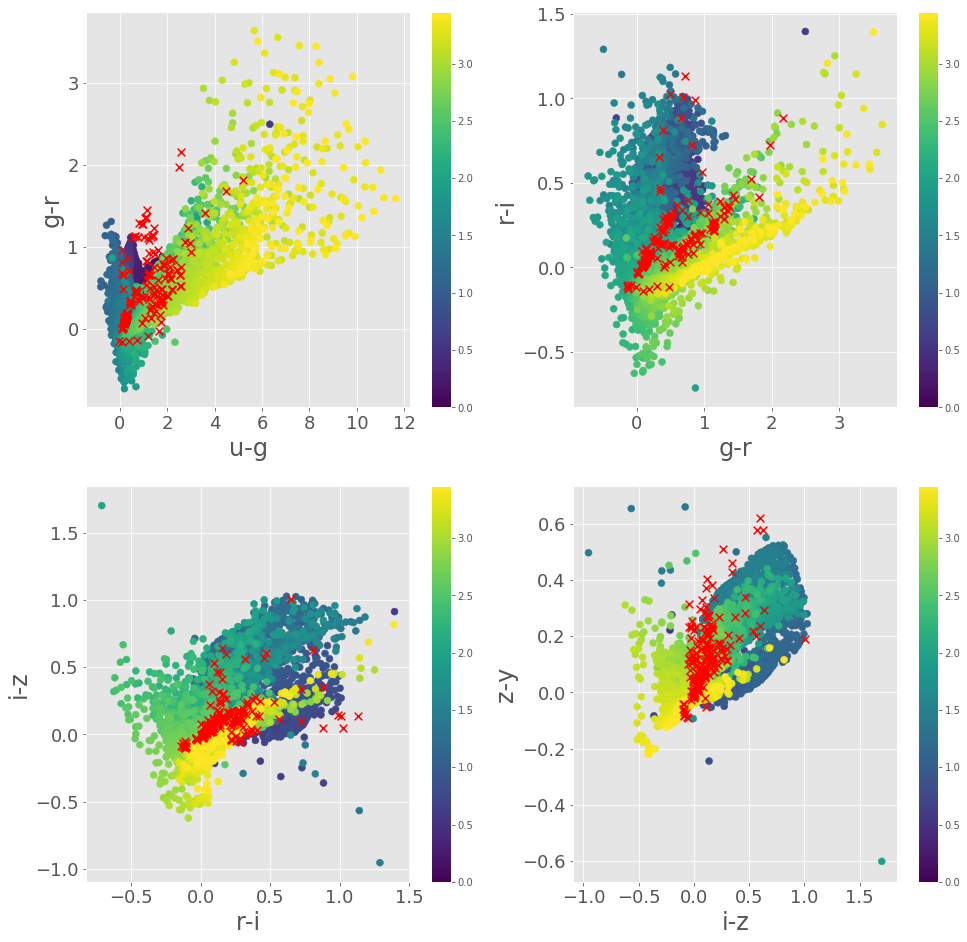

In [497]:
fig = plt.figure(figsize=(16,16))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(cluster_centers_gap[:,i], cluster_centers_gap[:,i+1], c=cl_z_full, s=48)
    plt.colorbar()
    plt.scatter(t_col[t_keep,i], t_col[t_keep,i+1], c='r', s=60, marker='x')
    plt.xlabel(colors[i], size=24)
    plt.ylabel(colors[i+1], size=24)
    plt.xticks(size=18)
    plt.yticks(size=18)

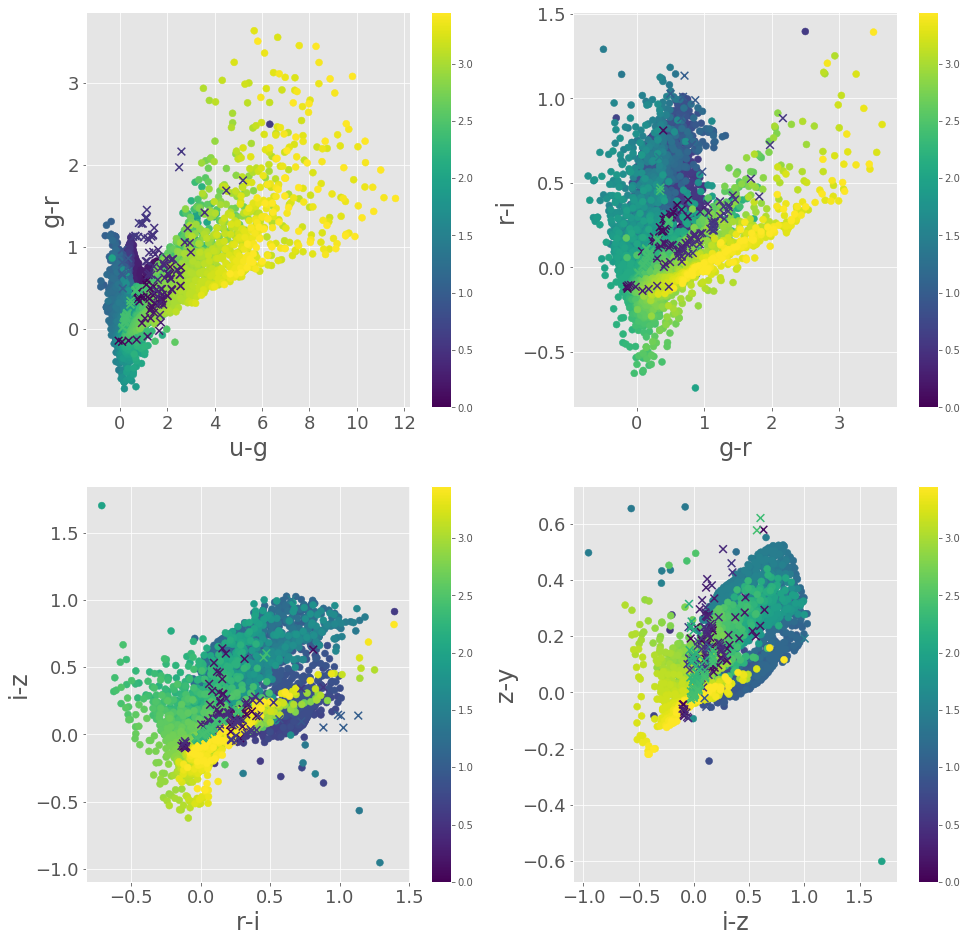

In [498]:
fig = plt.figure(figsize=(16,16))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(cluster_centers_gap[:,i], cluster_centers_gap[:,i+1], c=cl_z_full, s=48)
    plt.colorbar()
    plt.scatter(t_col[t_keep,i], t_col[t_keep,i+1], c=redshift_templates[t_keep], s=60, marker='x', vmax=3.5)
    plt.xlabel(colors[i], size=24)
    plt.ylabel(colors[i+1], size=24)
    plt.xticks(size=18)
    plt.yticks(size=18)

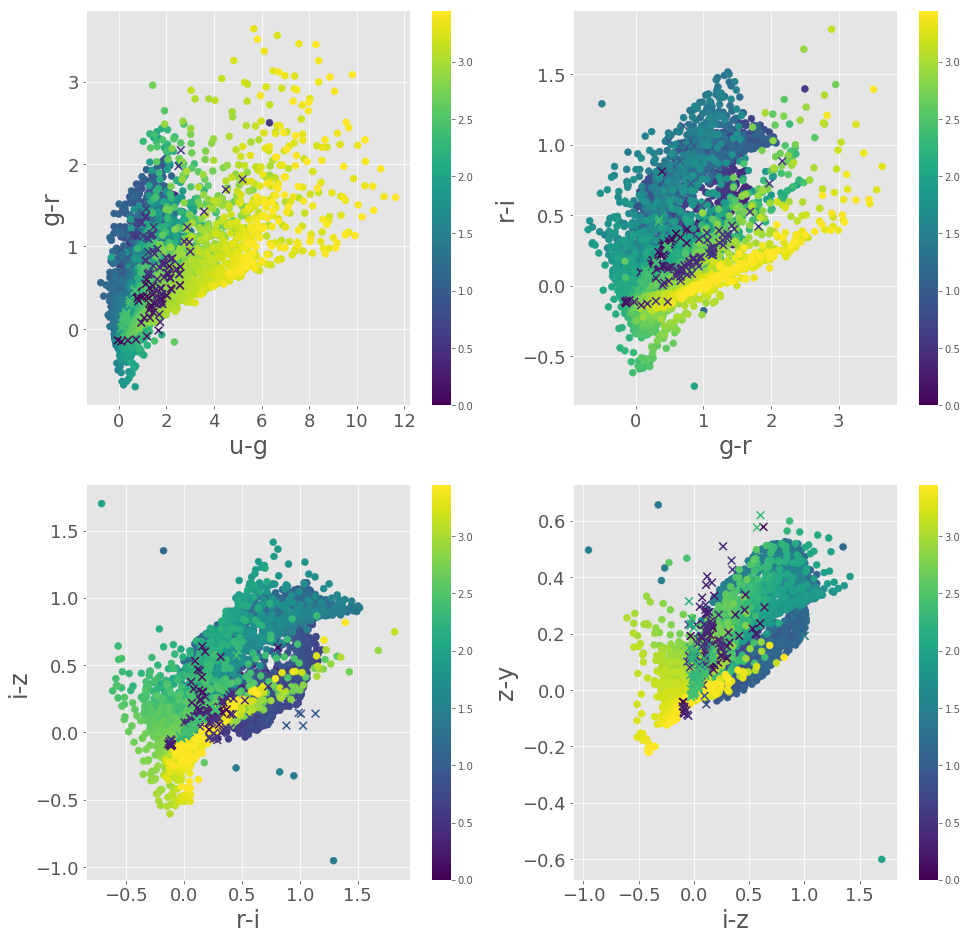

In [499]:
fig = plt.figure(figsize=(16,16))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(cluster_centers_full[:,i], cluster_centers_full[:,i+1], c=cl_z_full, s=48)
    plt.colorbar()
    plt.scatter(t_col[t_keep,i], t_col[t_keep,i+1], c=redshift_templates[t_keep], s=60, marker='x', vmax=3.5)
    plt.xlabel(colors[i], size=24)
    plt.ylabel(colors[i+1], size=24)
    plt.xticks(size=18)
    plt.yticks(size=18)

In [500]:
redshift_templates[t_keep]

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.05, 0.05, 0.05, 0.1 ,
       0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.2 , 0.2 ,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.35, 0.35, 0.35,
       0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.4 , 0.4 , 0.4 , 0.4 , 0.4 ,
       0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.45, 0.45, 0.45, 0.45,
       0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.5 , 0.5 , 0.5 , 0.5 ,
       0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.55, 0.55, 0.55, 0.55,
       0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.6 , 0.6 , 0.6 , 0.6 , 0.6 ,
       0.9 , 0.95, 1.  , 1.  , 1.  , 1.05, 1.05, 1.45, 2.2 , 2.2 , 2.2 ,
       2.2 , 2.2 , 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25,
       2.3 , 2.3 , 2.3 , 2.3 , 2.3 , 2.3 , 2.3 , 2.3 , 2.3 , 2.3 , 2.3 ,
       2.3 , 2.3 , 2.35, 2.35, 2.35, 2.35, 2.35, 2.

In [352]:
sim_cat_df = pd.DataFrame()
sim_cat_df['redshift'] = redshift_templates
for i, band in list(enumerate(filters)):
    # Going to use colors anyway so just give u-band standard magnitude
    sim_cat_df['%s' % band] = mags_templates[:,i]

In [501]:
sim_cat_df = pd.DataFrame()
sim_cat_df['redshift'] = redshift_templates[t_keep]
for i, band in list(enumerate(filters)):
    # Going to use colors anyway so just give u-band standard magnitude
    sim_cat_df['%s' % band] = mags_templates[t_keep,i]

In [503]:
sim_cat_df.to_csv('../data/rest_frame_templates_train.csv', index=False)